### 03_Entrenamiento_Evaluacion.ipynb:

Este notebook se dedicará al entrenamiento, la hiperparametrización, la evaluación y la interpretación de los modelos.

Preprocesamiento: Se utilizarán técnicas como One-Hot Encoding para variables categóricas y StandardScaler para las numéricas.

Modelos supervisados: Se entrenarán al menos 5 modelos, como Logistic Regression, Random Forest, Gradient Boosting, Support Vector Machine y XGBoost. Se utilizará Grid Search o Randomized Search para la hiperparametrización de al menos dos de ellos.

Modelo no supervisado: Se podría usar un algoritmo como K-Means para segmentar a los consumidores basándose en el tipo de queja y la respuesta de la compañía, para entender patrones sin la etiqueta de si disputaron o no.

Evaluación: Se utilizarán métricas como Accuracy, Precision, Recall, F1-score y ROC-AUC. Se generará una matriz de confusión para cada modelo y se interpretarán los resultados. Se evaluará el impacto en el negocio, por ejemplo, analizando el costo de no identificar una disputa (falsos negativos) en comparación con el costo de investigar una queja que no se disputará (falsos positivos). Finalmente, se seleccionará el modelo final basado en un análisis conjunto de métricas y su interpretación.

**Consideraciones previas:**

El objetivo es automatizar la clasificación de "Si el cliente disputará o No" la respuesta a su reclamación por parte de la empresa, sobre un producto financiero que ésta le ofrece, mejorando así la eficiencia con la que se resuelven.

Los modelos seleccionados se relacionaron con modelos de aprendizaje automático de clasificación supervisada con clasificación multiclases.

In [1]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, recall_score
from sklearn.metrics import classification_report, precision_score, recall_score
import pickle

In [2]:
# Paths
path_data = "C:/Users/aisat/Desktop/DSPT25_RA/3-DSPT2025-ML/Proy_Final_ML_RA/data/"
path_img = "C:/Users/aisat/Desktop/DSPT25_RA/3-DSPT2025-ML/Proy_Final_ML_RA/img/"
path_models = "C:/Users/aisat/Desktop/DSPT25_RA/3-DSPT2025-ML/Proy_Final_ML_RA/models/"

In [3]:
df_processed = pd.read_csv(path_data + 'df_processed.csv', sep=',', encoding='utf-8')
del df_processed["Unnamed: 0"]
df_processed.head()

,Complaint ID,Day received,Response time,Product_num,State_num,Timely_response_bin,Company_response_num,Consumer_disputed_num,Issue_num,Company_num
0,1177839,1,0,3,7,1,2,0,1,1940
1,1177844,1,0,9,44,1,1,1,4,112
2,1177846,1,0,3,40,1,2,0,4,1525
3,1177928,1,0,6,5,1,1,0,3,133
4,1177930,1,0,2,8,1,1,1,4,1430


In [4]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28156 entries, 0 to 28155
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   Complaint ID           28156 non-null  int64
 1   Day received           28156 non-null  int64
 2   Response time          28156 non-null  int64
 3   Product_num            28156 non-null  int64
 4   State_num              28156 non-null  int64
 5   Timely_response_bin    28156 non-null  int64
 6   Company_response_num   28156 non-null  int64
 7   Consumer_disputed_num  28156 non-null  int64
 8   Issue_num              28156 non-null  int64
 9   Company_num            28156 non-null  int64
dtypes: int64(10)
memory usage: 2.1 MB


In [5]:
Target = df_processed['Consumer_disputed_num']

- **Distribución de la variable Objetivo**

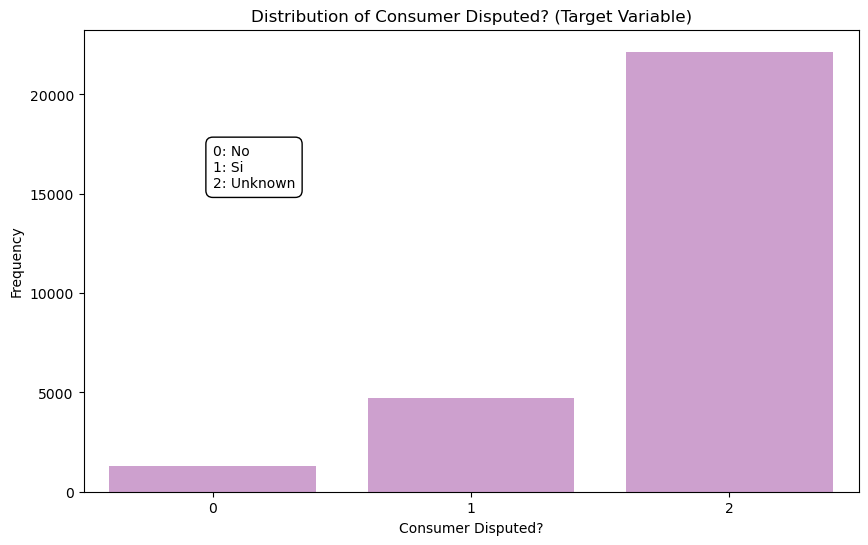

In [6]:
labels={0: 'No', 1: 'Si', 2: 'Unknown'}

plt.figure(figsize=(10, 6))
sns.barplot(x=Target.value_counts().index, y=Target.value_counts().values, color='#AC32AE', alpha=0.5)
plt.title("Distribution of Consumer Disputed? (Target Variable)")
plt.xlabel("Consumer Disputed?")
plt.ylabel("Frequency")
# Format the annotation text
annotation_text = "\n".join([f"{k}: {v}" for k, v in labels.items()])

# Add annotation box inside the plot (top-right corner)
plt.text(
    x=0, y= 17500,
    s=annotation_text,
    ha='left', va='top',
    fontsize=10,
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
)
plt.savefig( path_img + "Distribution_of_Target_Variable_ConsumerDisputed.tiff")

In [7]:
Target.value_counts()

Consumer_disputed_num
2    22150
1     4708
0     1298
Name: count, dtype: int64

- **Features**

In [8]:
Features = df_processed.drop(columns=['Consumer_disputed_num'])

- **Feature importance**

In [9]:
names = Features.columns
rf = RandomForestClassifier(n_estimators = 100)
rf.fit(Features, Target)

scores = sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), reverse=True)
pd.DataFrame(scores, columns=['Score', 'Feature'])

,Score,Feature
0,0.3234,Complaint ID
1,0.1717,State_num
2,0.1655,Company_num
3,0.1469,Day received
4,0.0702,Response time
5,0.0522,Product_num
6,0.0348,Company_response_num
7,0.0300,Issue_num
8,0.0054,Timely_response_bin


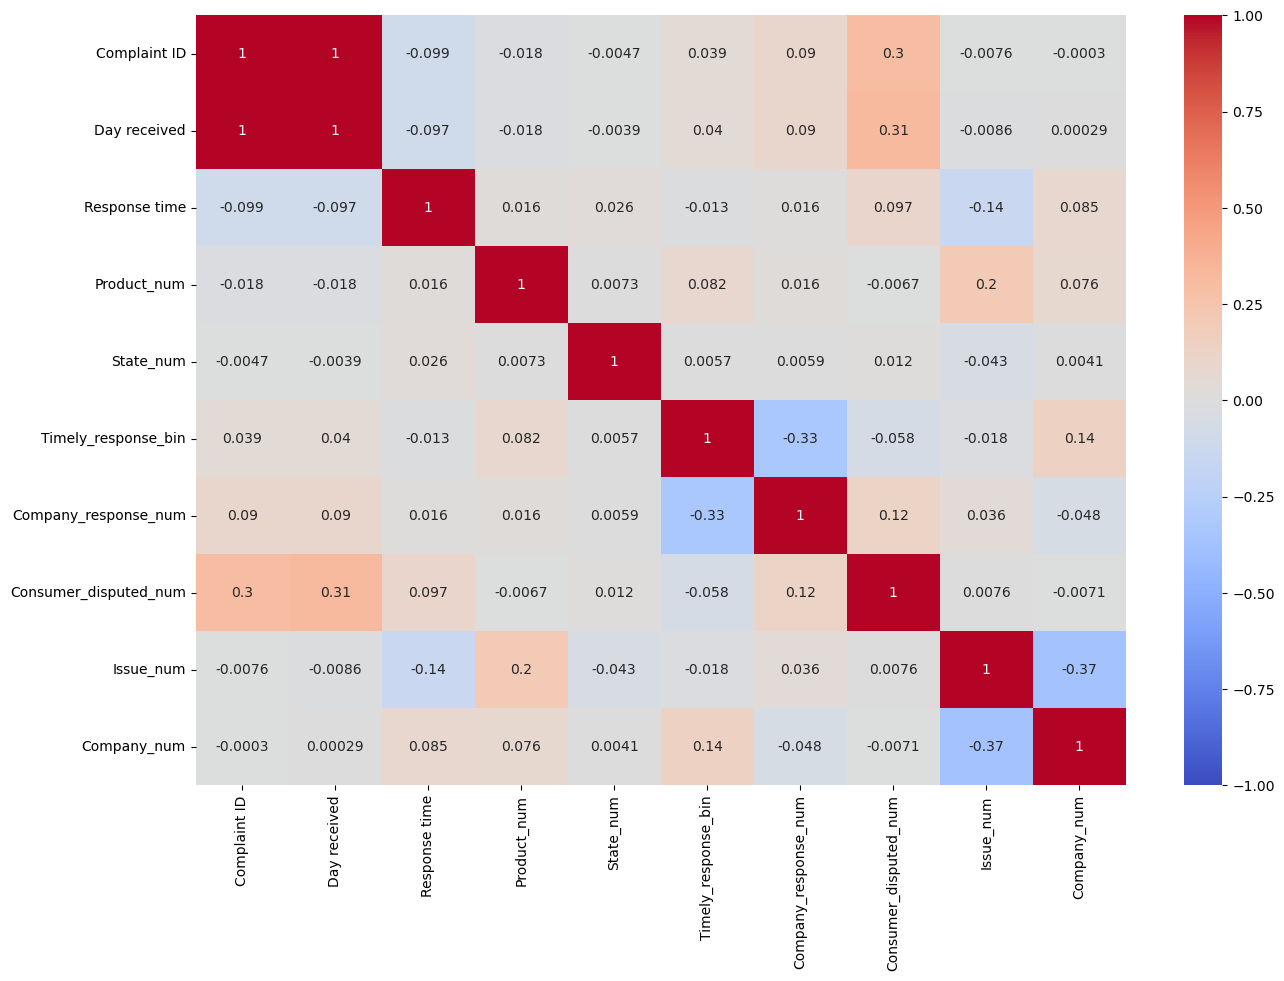

In [10]:
# Heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(df_processed.corr(), annot_kws={'fontsize': 10},vmin=-1, vmax=1, cmap ="coolwarm", annot=True);
plt.savefig(path_img + 'Heatmap Pearson.tiff')

### **Target: Consumer Disputed?**

#### **1.Preparing the data for training**

In [27]:
X_train, X_test, y_train, y_test = train_test_split(Features, Target, stratify=Target, test_size=0.20, random_state= 42, shuffle=True)
#Stratify for mantaining the same proporcion of classes in Train and Test
print('X_train_shape: ',  X_train.shape)
print('y_train_shape: ',  y_train.shape)

print('\nX_test_shape: ',  X_test.shape)
print('y_test_shape: ',  y_test.shape)

X_train_shape:  (22524, 9)
y_train_shape:  (22524,)

X_test_shape:  (5632, 9)
y_test_shape:  (5632,)


In [15]:
over_strategy = {0: 8000, 1: 4000}  # To increase the values of the minority classes
under_strategy = {1: 4000} # To decrease the value of the majority class (2) 

In [16]:
smote = SMOTE(
    sampling_strategy=over_strategy,
    random_state=42,
    k_neighbors= 3  # 3 cluster since over_strategy variable contain 3 classes
)

X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

In [17]:
undersampler = NearMiss(sampling_strategy=under_strategy)

X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train_over, y_train_over)

In [18]:
normalizer = preprocessing.QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=42)
X_train_normalized = normalizer.fit_transform(X_train_balanced)
X_test_normalized = normalizer.transform(X_test)

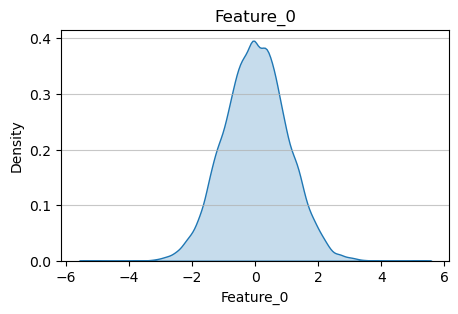

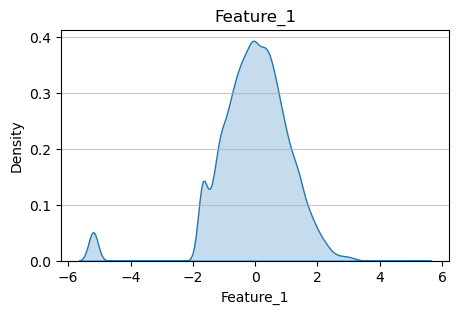

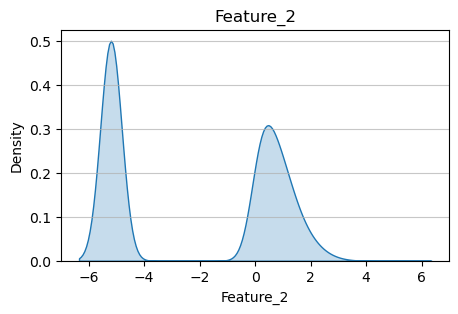

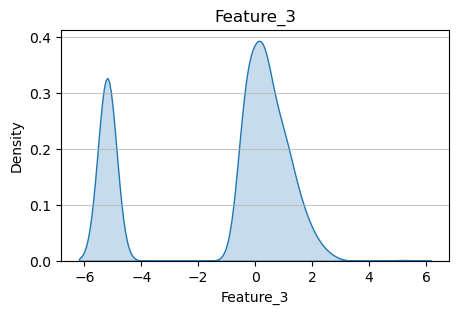

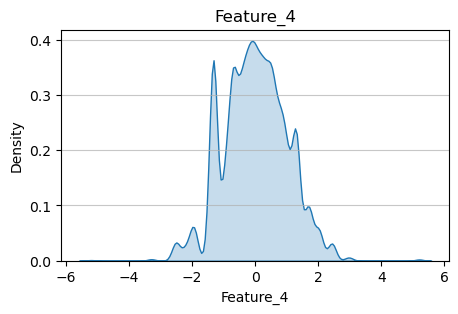

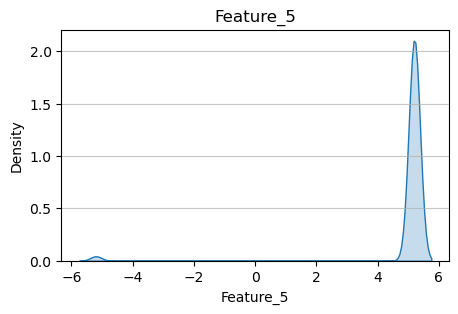

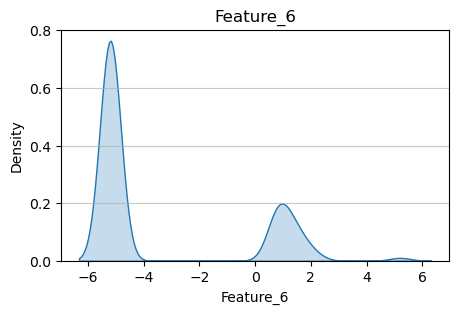

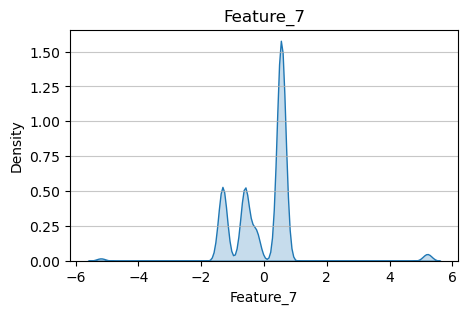

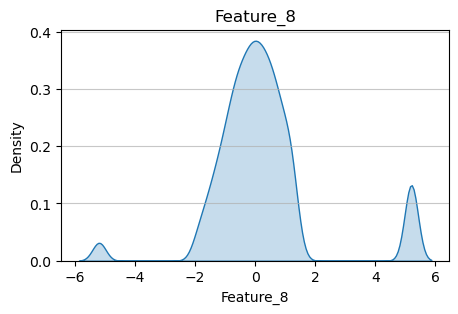

In [19]:
# Visualizing the normalized data
df_normalized = pd.DataFrame(X_train_normalized, columns=[f'Feature_{i}' for i in range(X_train_normalized.shape[1])])
for columns in df_normalized.columns: 
    plt.figure(figsize=(5,3))
    sns.kdeplot(df_normalized[columns], fill=True);
    plt.title(columns)
    plt.xlabel(columns)
    plt.ylabel('Density')
    plt.grid(axis='y', alpha=0.7)
    plt.show();

- La normalización no mejoró la distribución de los datos. Finalmente no se va ha considerar la transformación de los datos para obtener una distribución normal.

In [20]:
#Escalado de los datos sin considerar la transformación de la distribución de los datos.
scaler  = preprocessing.MinMaxScaler().fit(X_train_balanced)
X_train_scal_re = scaler.transform(X_train_balanced)

X_train_scal_re

array([[0.00852824, 0.01298701, 0.        , ..., 0.        , 0.4       ,
        0.01904297],
       [0.06321397, 0.07792208, 0.        , ..., 0.        , 0.4       ,
        0.00683594],
       [0.03068418, 0.05194805, 0.        , ..., 0.6       , 0.8       ,
        0.62060547],
       ...,
       [0.63758025, 0.64935065, 0.015625  , ..., 0.        , 0.2       ,
        0.74414062],
       [0.77226528, 0.77922078, 0.015625  , ..., 0.4       , 0.8       ,
        0.27636719],
       [0.56997533, 0.61038961, 0.        , ..., 0.        , 0.6       ,
        0.01025391]])

In [21]:
X_test_scal = scaler.transform(X_test)

#### **2. Modelos**

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pickle

# Ignoramos los warnings
import warnings
warnings.filterwarnings("ignore")

### **Preprocesado**

In [ ]:
# Paths
path_data = "C:/Users/aisat/Desktop/DSPT25_RA/3-DSPT2025-ML/Proy_Final_ML_RA/data/"
path_img = "C:/Users/aisat/Desktop/DSPT25_RA/3-DSPT2025-ML/Proy_Final_ML_RA/img/"
path_models = "C:/Users/aisat/Desktop/DSPT25_RA/3-DSPT2025-ML/Proy_Final_ML_RA/3.models/"

# Cargar el dataframe preprocesado
df_processed = pd.read_csv(path_data + 'df_processed.csv', sep=',', encoding='utf-8')
del df_processed["Unnamed: 0"]
df_processed.head()

# Separar características (X) y variable objetivo (y)
X = df_processed.drop('Consumer_disputed_num', axis=1)
y = df_processed['Consumer_disputed_num']

# Definir las columnas numéricas y categóricas
numerical_features = X.select_dtypes(include=['number']).columns.tolist()
categorical_features = X.select_dtypes(exclude=['number']).columns.tolist()

# Crear los transformadores para las columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        remainder='passthrough'
    ])

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
# Crear el pipeline que encadena el preprocesamiento y el modelo de regresión logística
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])

# Entrenar el modelo
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['Complaint ID',
                                                   'Day received',
                                                   'Response time',
                                                   'Product_num', 'State_num',
                                                   'Timely_response_bin',
                                                   'Company_response_num',
                                                   'Issue_num',
                                                   'Company_num']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  [])])),
                ('classifier', LogisticRegression(random_state=42))])

### **Entrenamiento**

In [ ]:
# Diccionario para almacenar los modelos entrenados
trained_models = {}
# Diccionario para almacenar los resultados
model_results = {}
for name, model in models.items():
    print(f"\nEntrenando {name}...")
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)]) # Crear el pipeline de preprocesamiento y entrenamiento
    pipeline.fit(X_train, y_train) # Entrenar el pipeline en el conjunto de entrenamiento
    trained_models[name] = pipeline
    trained_models[name] = pipeline
    print(f"Modelo {name} entrenado.")
    
    # Guardar el modelo entrenado
    joblib.dump(pipeline, f'{path_models} trained_model_{name.lower().replace(" ", "_")}.pkl')
    print(f"Modelo {name} guardado en '{path_models}trained_model_{name.lower().replace(' ', '_')}.pkl'.")

     # 1. Obtener predicciones y probabilidades para el conjunto de ENTRENAMIENTO
    train_pred = pipeline.predict(X_train)
    train_prob = pipeline.predict_proba(X_train)[:, 1]  # Probabilidad de la clase positiva (disputada)
    # 2. Obtener predicciones y probabilidades para el conjunto de PRUEBA
    test_pred = pipeline.predict(X_test)
    test_prob = pipeline.predict_proba(X_test)[:, 1]  # Probabilidad de la clase positiva (disputada)
    # Almacenar los resultados en el diccionario
    model_results[name] = {
        'train_pred': train_pred,
        'train_prob': train_prob,
        'test_pred': test_pred,
        'test_prob': test_prob
    }
    print(f"Predicciones y probabilidades obtenidas para {name}.")
    
print("\n--- Obteniendo predicciones y probabilidades para cada modelo ---")
# 3. Mostrar un resumen de los resultados
print("\n--- Resumen de los Resultados ---")
for name, results in model_results.items():
    print(f"\nModelo: {name}")
    
    # Mostrar las primeras 5 predicciones del conjunto de entrenamiento
    print(f"  - Predicciones de train (primeras 5): {results['train_predictions'][:5]}")
    print(f"  - Probabilidades de train (primeras 5): {[f'{p:.4f}' for p in results['train_probabilities'][:5]]}")
    
    # Mostrar las primeras 5 predicciones del conjunto de prueba
    print(f"  - Predicciones de test (primeras 5): {results['test_predictions'][:5]}")
    print(f"  - Probabilidades de test (primeras 5): {[f'{p:.4f}' for p in results['test_probabilities'][:5]]}")



Entrenando Logistic Regression...
Modelo Logistic Regression entrenado.
Modelo Logistic Regression guardado en 'C:/Users/aisat/Desktop/DSPT25_RA/3-DSPT2025-ML/Proy_Final_ML_RA/3.models/trained_model_logistic_regression.pkl'.
Predicciones y probabilidades obtenidas para Logistic Regression.
Modelo Logistic Regression entrenado.

Entrenando Random Forest...
Modelo Random Forest entrenado.
Modelo Random Forest guardado en 'C:/Users/aisat/Desktop/DSPT25_RA/3-DSPT2025-ML/Proy_Final_ML_RA/3.models/trained_model_random_forest.pkl'.
Predicciones y probabilidades obtenidas para Random Forest.
Modelo Random Forest entrenado.

Entrenando Gradient Boosting...
Modelo Gradient Boosting entrenado.
Modelo Gradient Boosting guardado en 'C:/Users/aisat/Desktop/DSPT25_RA/3-DSPT2025-ML/Proy_Final_ML_RA/3.models/trained_model_gradient_boosting.pkl'.
Predicciones y probabilidades obtenidas para Gradient Boosting.
Modelo Gradient Boosting entrenado.

Entrenando XGBoost...
Modelo XGBoost entrenado.
Modelo XG

### **Hiperparametrzación**

**Hiperparametrización: Regresión Logistica y SVC**

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, make_scorer

# Define el scorer para roc_auc en un escenario multiclase
# 'ovo' (One-vs-One) es una buena opción para multiclase
roc_auc_multiclass = make_scorer(roc_auc_score, needs_proba=True, average='ovo', multi_class='ovo')

# También puedes usar 'ovr' (One-vs-Rest)
# roc_auc_multiclass_ovr = make_scorer(roc_auc_score, needs_proba=True, average='macro', multi_class='ovr')

# 2.Hiperparámetros para Regresión Logística
logreg_params = {
    'classifier': [LogisticRegression(random_state=42, solver='saga', max_iter=200)],
    'classifier__C': [0.1, 1.0, 10],
    'classifier__penalty': ['l1', 'l2']
}

print("Iniciando GridSearchCV para Regresión Logística...")
grid_search_logreg = GridSearchCV(pipeline, logreg_params, cv=3, scoring= roc_auc_multiclass, n_jobs=-1, verbose=1)
grid_search_logreg.fit(X_train, y_train)

print("\nMejores parámetros para Regresión Logística:")
print(grid_search_logreg.best_params_)
print(f"ROC-AUC score en CV: {grid_search_logreg.best_score_:.4f}")

Iniciando GridSearchCV para Regresión Logística...
Fitting 3 folds for each of 6 candidates, totalling 18 fits

Mejores parámetros para Regresión Logística:
{'classifier': LogisticRegression(max_iter=200, random_state=42, solver='saga'), 'classifier__C': 0.1, 'classifier__penalty': 'l1'}
ROC-AUC score en CV: nan


In [ ]:
# Hiperparámetros para SVC
svc_params = {
    'classifier': [SVC(random_state=42, probability=True)],
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['rbf', 'poly'],
    'classifier__gamma': ['scale', 'auto']
}

print("Iniciando GridSearchCV para SVC...")
grid_search_svc = GridSearchCV(pipeline, svc_params, cv=3, scoring=roc_auc_multiclass, n_jobs=-1, verbose=1)
grid_search_svc.fit(X_train, y_train)

print("\nMejores parámetros para SVC:")
print(grid_search_svc.best_params_)
print(f"ROC-AUC score en CV: {grid_search_svc.best_score_:.4f}")

**Hiperparametrización: RandomForest, Gradient Boosting, XGBoost y LightGBM**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import scipy.stats as stats
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Hiperparámetros para Random Forest
rf_params = {
    'classifier': [RandomForestClassifier(random_state=42)],
    'classifier__n_estimators': stats.randint(100, 500),
    'classifier__max_depth': stats.randint(5, 30),
    'classifier__min_samples_split': stats.randint(2, 10),
    'classifier__min_samples_leaf': stats.randint(1, 5)
}

# Binarize the true labels for multiclass
y_true_binarized = label_binarize(y_true, classes=[0, 1, 2])

# Compute multiclass ROC-AUC (OvR by default)
roc_auc_ovr = roc_auc_score(y_true_binarized, y_pred_proba, multi_class="ovr")
print("ROC-AUC (OvR):", roc_auc_ovr)

# Compute multiclass ROC-AUC (OvO)
roc_auc_ovo = roc_auc_score(y_true_binarized, y_pred_proba, multi_class="ovo")
print("ROC-AUC (OvO):", roc_auc_ovo)

# Define el scorer para roc_auc en un escenario multiclase
# 'ovo' (One-vs-One) es una buena opción para multiclase
roc_auc_multiclass = make_scorer(roc_auc_score, needs_proba=True, average='ovo', multi_class='ovo')

print("Iniciando RandomizedSearchCV para Random Forest...")
random_search_rf = RandomizedSearchCV(pipeline, rf_params, n_iter=20, cv=3, scoring= roc_auc_multiclass, random_state=42, n_jobs=-1, verbose=1)
random_search_rf.fit(X_train, y_train)

print("\nMejores parámetros para Random Forest:")
print(random_search_rf.best_params_)
print(f"ROC-AUC score en CV: {random_search_rf.best_score_:.4f}")
print("---")

# Hiperparámetros para Gradient Boosting
gb_params = {
    'classifier': [GradientBoostingClassifier(random_state=42)],
    'classifier__n_estimators': stats.randint(100, 500),
    'classifier__learning_rate': stats.uniform(0.01, 0.2),
    'classifier__max_depth': stats.randint(3, 10)
}

print("Iniciando RandomizedSearchCV para Gradient Boosting...")
random_search_gb = RandomizedSearchCV(pipeline, gb_params, n_iter=20, cv=3, scoring= roc_auc_multiclass, random_state=42, n_jobs=-1, verbose=1)
random_search_gb.fit(X_train, y_train)

print("\nMejores parámetros para Gradient Boosting:")
print(random_search_gb.best_params_)
print(f"ROC-AUC score en CV: {random_search_gb.best_score_:.4f}")
print("---")

# Hiperparámetros para XGBoost
xgb_params = {
    'classifier': [XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')],
    'classifier__n_estimators': stats.randint(100, 500),
    'classifier__learning_rate': stats.uniform(0.01, 0.2),
    'classifier__max_depth': stats.randint(3, 10),
    'classifier__subsample': stats.uniform(0.6, 0.4)
}

print("Iniciando RandomizedSearchCV para XGBoost...")
random_search_xgb = RandomizedSearchCV(pipeline, xgb_params, n_iter=20, cv=3, scoring= roc_auc_multiclass, random_state=42, n_jobs=-1, verbose=1)
random_search_xgb.fit(X_train, y_train)

print("\nMejores parámetros para XGBoost:")
print(random_search_xgb.best_params_)
print(f"ROC-AUC score en CV: {random_search_xgb.best_score_:.4f}")

# Hiperparámetros para XGBoost
lgbm_params =  {
    'classifier__n_estimators': [100, 200, 500],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__num_leaves': [8, 32, 128],
    'classifier__max_depth': [3, 5, 7]
}

print("Iniciando RandomizedSearchCV para LightGBM...")
random_search_lgbm = RandomizedSearchCV(pipeline, lgbm_params, n_iter=20, cv=3, scoring= roc_auc_multiclass, random_state=42, n_jobs=-1, verbose=1)
random_search_lgbm.fit(X_train, y_train)

print("\nMejores parámetros para LightGBM:")
print(random_search_lgbm.best_params_)
print(f"ROC-AUC score en CV: {random_search_lgbm.best_score_:.4f}")

Iniciando RandomizedSearchCV para Random Forest...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Mejores parámetros para Random Forest:
{'classifier': RandomForestClassifier(random_state=42), 'classifier__max_depth': 11, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 6, 'classifier__n_estimators': 370}
ROC-AUC score en CV: nan
---
Iniciando RandomizedSearchCV para Gradient Boosting...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Mejores parámetros para Gradient Boosting:
{'classifier': GradientBoostingClassifier(random_state=42), 'classifier__learning_rate': np.float64(0.0849080237694725), 'classifier__max_depth': 7, 'classifier__n_estimators': 370}
ROC-AUC score en CV: nan
---
Iniciando RandomizedSearchCV para XGBoost...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Mejores parámetros para XGBoost:
{'classifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsa

ValueError: Invalid parameter 'num_leaves' for estimator SVC(probability=True, random_state=42). Valid parameters are: ['C', 'break_ties', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose'].

In [60]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Example data
y_true = [0, 1, 2, 2, 0]  # True labels
y_pred_proba = [
    [0.9, 0.05, 0.05],  # Predicted probabilities for each class
    [0.1, 0.8, 0.1],
    [0.2, 0.2, 0.6],
    [0.1, 0.3, 0.6],
    [0.7, 0.2, 0.1]
]

# Binarize the true labels for multiclass
y_true_binarized = label_binarize(y_true, classes=[0, 1, 2])

# Compute multiclass ROC-AUC (OvR by default)
roc_auc_ovr = roc_auc_score(y_true_binarized, y_pred_proba, multi_class="ovr")
print("ROC-AUC (OvR):", roc_auc_ovr)

# Compute multiclass ROC-AUC (OvO)
roc_auc_ovo = roc_auc_score(y_true_binarized, y_pred_proba, multi_class="ovo")
print("ROC-AUC (OvO):", roc_auc_ovo)

ROC-AUC (OvR): 1.0
ROC-AUC (OvO): 1.0


### **Evaluación de Modelos**


--- 3. Evaluación de Modelos ---

--- Resultados para Logistic Regression ---
              precision    recall  f1-score   support

           0       0.47      0.34      0.40       254
           1       0.00      0.00      0.00       958
           2       0.80      0.99      0.88      4420

    accuracy                           0.79      5632
   macro avg       0.42      0.44      0.43      5632
weighted avg       0.65      0.79      0.71      5632



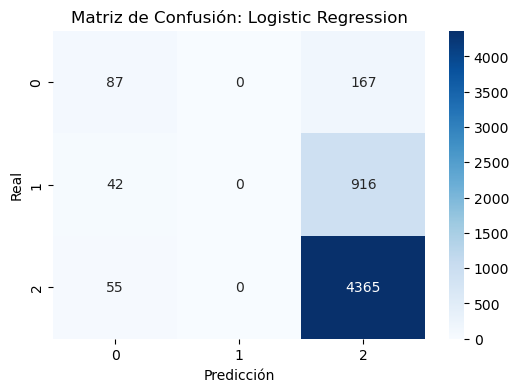


--- Resultados para Random Forest ---
              precision    recall  f1-score   support

           0       0.50      0.49      0.49       254
           1       0.30      0.07      0.12       958
           2       0.82      0.95      0.88      4420

    accuracy                           0.78      5632
   macro avg       0.54      0.50      0.50      5632
weighted avg       0.72      0.78      0.73      5632



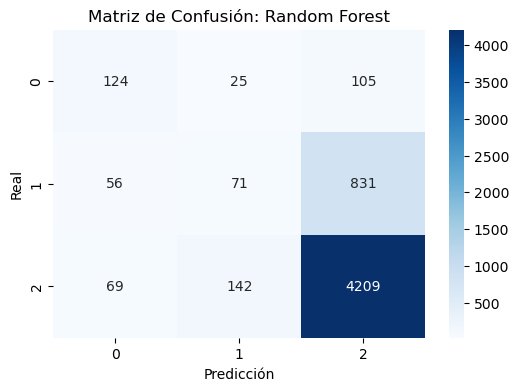


--- Resultados para Gradient Boosting ---
              precision    recall  f1-score   support

           0       0.51      0.52      0.51       254
           1       0.33      0.00      0.01       958
           2       0.81      0.98      0.89      4420

    accuracy                           0.80      5632
   macro avg       0.55      0.50      0.47      5632
weighted avg       0.72      0.80      0.72      5632



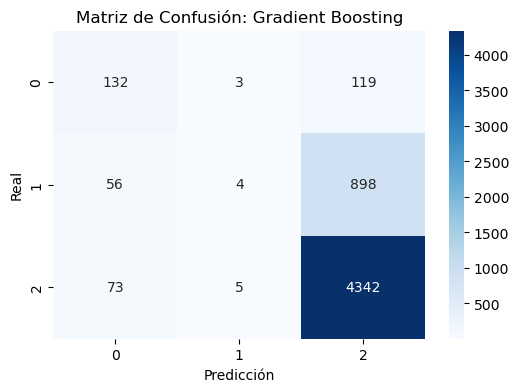


--- Resultados para XGBoost ---
              precision    recall  f1-score   support

           0       0.55      0.59      0.57       254
           1       0.29      0.03      0.05       958
           2       0.82      0.97      0.89      4420

    accuracy                           0.80      5632
   macro avg       0.55      0.53      0.50      5632
weighted avg       0.71      0.80      0.73      5632



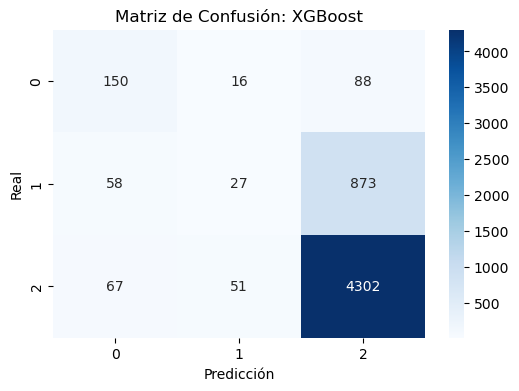


--- Resultados para LightGBM ---
              precision    recall  f1-score   support

           0       0.53      0.59      0.56       254
           1       0.33      0.01      0.02       958
           2       0.82      0.98      0.89      4420

    accuracy                           0.80      5632
   macro avg       0.56      0.53      0.49      5632
weighted avg       0.72      0.80      0.73      5632



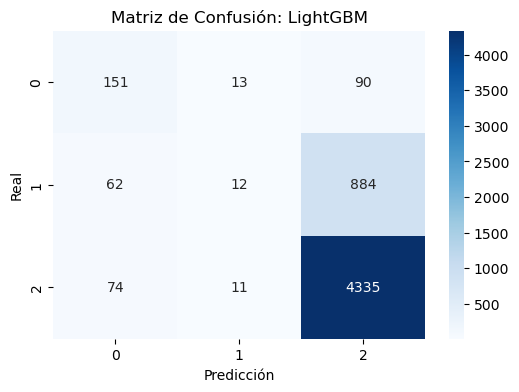


--- Resultados para SVC ---
              precision    recall  f1-score   support

           0       0.52      0.38      0.44       254
           1       0.00      0.00      0.00       958
           2       0.80      0.99      0.89      4420

    accuracy                           0.79      5632
   macro avg       0.44      0.46      0.44      5632
weighted avg       0.65      0.79      0.71      5632



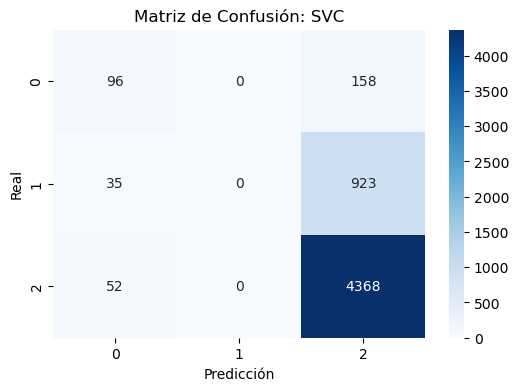

In [10]:
# 3. Evaluación de modelos
print("\n--- 3. Evaluación de Modelos ---")
evaluation_results = {}
for name, model in trained_models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    report = classification_report(y_test, y_pred, output_dict=True)
        
    evaluation_results[name] = {
        'report': report,
        #'roc_auc': roc_auc
    }
    
    print(f"\n--- Resultados para {name} ---")
    # print(f"ROC-AUC: {roc_auc:.4f}")
    print(classification_report(y_test, y_pred))
    
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusión: {name}')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()

In [ ]:
# Compute multiclass ROC-AUC (OvO)
roc_auc_ovo = roc_auc_score(y_true_binarized, y_proba_rf, multi_class="ovo")
print(f"ROC-AUC (OvO) en el conjunto de prueba: {roc_auc_ovo:4f}")
# print(f"ROC-AUC (OvO) en el conjunto de prueba: {roc_auc_score(y_test, y_proba_rf):.4f}")

# Compute multiclass ROC-AUC (OvR by default)
roc_auc_ovr = roc_auc_score(y_true_binarized, y_proba_rf, multi_class="ovr")
print("ROC-AUC (OvR):", roc_auc_ovr)


### **Modelo Final**

In [ ]:
# 4. Interpretación y selección del modelo final
print("\n--- 4. Interpretación y Selección del Modelo Final ---")

# Comparar ROC-AUC de todos los modelos
roc_auc_scores = {name: result['roc_auc'] for name, result in evaluation_results.items()}
print("\nROC-AUC de todos los modelos:")
print(roc_auc_scores)
print("\nEl modelo con el mejor rendimiento (mayor ROC-AUC) es el candidato a ser el modelo final.")

# Se selecciona el mejor modelo (ej. XGBoost suele tener un buen rendimiento)
final_model = trained_models['XGBoost'] # Reemplazar con el modelo de mejor rendimiento
joblib.dump(final_model, 'models/final_model.pkl')
print("\nEl modelo final ha sido guardado en 'models/final_model.pkl'.")

# Guardar la configuración (ej. de XGBoost)
config = final_model.named_steps['classifier'].get_params()
with open('models/model_config.yaml', 'w') as f:
    import yaml
    yaml.dump(config, f)
print("Configuración del modelo final guardada en 'models/model_config.yaml'.")

In [32]:
# 5. Pasos adicionales (ejemplo de modelo no supervisado)
# Se podría aplicar K-Means para agrupar quejas
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

print("\n--- 5. Ejemplo de Modelo No Supervisado ---")
print("Aplicando K-Means para segmentación de quejas...")

# Usar las mismas características preprocesadas, pero sin la variable objetivo
X_unsupervised = df_relleno.drop('Consumer disputed?', axis=1)

# Pipeline de preprocesamiento para K-Means
preprocessor_kmeans = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

X_unsupervised_processed = preprocessor_kmeans.fit_transform(X_unsupervised)

# Entrenar K-Means con un número arbitrario de clusters (ej. 3)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_unsupervised_processed)

df_relleno['Cluster'] = clusters
print("Clusters asignados al DataFrame.")
print("Distribución de quejas por cluster:")
print(df['Cluster'].value_counts())
print("\nEl análisis de estos clusters podría revelar patrones de quejas no evidentes en el análisis supervisado.")


--- 3. Evaluación de Modelos ---


c:\Users\aisat\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aisat\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aisat\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

ValueError: multi_class must be in ('ovo', 'ovr')

**Hiperparametrización: Todos los modelos**

In [ ]:
# Definir los modelos y sus respectivos espacios de búsqueda
models_to_tune = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42),
        'search': 'grid',
        'params': {
            'classifier__C': [0.01, 0.1, 1, 10, 100],
            'classifier__solver': ['liblinear', 'lbfgs']
        }
    },
    'SVC': {
        'model': SVC(random_state=42, probability=True),
        'search': 'grid',
        'params': {
            'classifier__C': [0.1, 1, 10],
            'classifier__kernel': ['linear', 'rbf']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'search': 'random',
        'params': {
            'classifier__n_estimators': [100, 200, 500],
            'classifier__max_depth': [10, 20, None],
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__min_samples_leaf': [1, 2, 4]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'search': 'random',
        'params': {
            'classifier__n_estimators': [100, 200, 500],
            'classifier__learning_rate': [0.01, 0.1, 0.2],
            'classifier__max_depth': [3, 5, 7],
            'classifier__subsample': [0.7, 0.8, 0.9]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
        'search': 'random',
        'params': {
            'classifier__n_estimators': [100, 200, 500],
            'classifier__learning_rate': [0.01, 0.1, 0.2],
            'classifier__max_depth': [3, 5, 7],
            'classifier__subsample': [0.7, 0.8, 0.9],
            'classifier__colsample_bytree': [0.7, 0.8, 0.9]
        }
    },
    'LightGBM': {
        'model': LGBMClassifier(random_state=42),
        'search': 'random',
        'params': {
            'classifier__n_estimators': [100, 200, 500],
            'classifier__learning_rate': [0.01, 0.1, 0.2],
            'classifier__num_leaves': [31, 50, 100],
            'classifier__max_depth': [10, 20, -1]
        }
    }
}

best_models = {}

for name, config in models_to_tune.items():
    print(f"--- Hiperparametrizando {name} con {config['search']} search ---")
    
    # Crear el pipeline para el modelo actual
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', config['model'])
    ])
    
    # Seleccionar el método de búsqueda
    if config['search'] == 'grid':
        searcher = GridSearchCV(pipeline, config['params'], cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)
    else: # random
        searcher = RandomizedSearchCV(pipeline, config['params'], n_iter=20, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1, random_state=42)
        
    searcher.fit(X_train, y_train)
    
    # Guardar los resultados y el mejor modelo
    best_models[name] = {
        'best_score': searcher.best_score_,
        'best_params': searcher.best_params_,
        'best_model': searcher.best_estimator_
    }
    
    print(f"Mejor ROC-AUC para {name}: {best_models[name]['best_score']:.4f}")
    print(f"Mejores parámetros: {best_models[name]['best_params']}\n")
    
    # Opcionalmente, guardar el mejor modelo en un archivo
    joblib.dump(best_models[name]['best_model'], f'models/best_model_{name.lower().replace(" ", "_")}.pkl')

# 3. Comparación y selección del modelo final
print("--- Resumen de los Mejores Modelos ---")
for name, result in best_models.items():
    print(f"{name}: ROC-AUC = {result['best_score']:.4f}")

# Seleccionar el mejor modelo basado en el ROC-AUC
final_model_name = max(best_models, key=lambda k: best_models[k]['best_score'])
final_model = best_models[final_model_name]['best_model']

print(f"\nEl modelo final seleccionado es: {final_model_name} con un ROC-AUC de {best_models[final_model_name]['best_score']:.4f}")

# Guardar el modelo final y su configuración
joblib.dump(final_model, 'models/final_model.pkl')